<div class="alert alert-block alert-info" style="margin-top: 20px">
 <a href="http://cocl.us/pytorch_link_top"><img src = "http://cocl.us/Pytorch_top" width = 950, align = "center"></a>

<img src = "https://ibm.box.com/shared/static/ugcqz6ohbvff804xp84y4kqnvvk3bq1g.png" width = 200, align = "center">


<h1 align=center><font size = 5>Convolutional Neral Network </font></h1> 


# Table of Contents
In this lab, we will use a Convolutional Neral Networks to classify handwritten digits from the MNIST database

<div class="alert alert-block alert-info" style="margin-top: 20px">
<li><a href="#ref0">Helper functions </a></li>

<li><a href="#ref1"> Prepare Data </a></li>
<li><a href="#ref2">Convolutional Neral Network </a></li>
<li><a href="#ref3">Define Softmax , Criterion function, Optimizer and Train the  Model</a></li>
<li><a href="#ref4">Analyse Results</a></li>

<br>
<p></p>
Estimated Time Needed: <strong>25 min</strong>
</div>

<hr>

<a id="ref0"></a>
<h2 align=center>Helper functions </h2>

In [1]:
import torch 
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import matplotlib.pylab as plt
import numpy as np


<code>plot_channels</code>: 
plot out the kernel parameters of  each channel 

In [2]:
def plot_channels(W):
    #number of output channels 
    n_out=W.shape[0]
    #number of input channels 
    n_in=W.shape[1]
    w_min=W.min().item()
    w_max=W.max().item()
    fig, axes = plt.subplots(n_out,n_in)
    fig.subplots_adjust(hspace = 0.1)
    out_index=0
    in_index=0
    #plot outputs as rows inputs as columns 
    for ax in axes.flat:
    
        if in_index>n_in-1:
            out_index=out_index+1
            in_index=0
              
        ax.imshow(W[out_index,in_index,:,:], vmin=w_min, vmax=w_max, cmap='seismic')
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        in_index=in_index+1

    plt.show()

<code>plot_parameters</code>: plot out the kernel parameters of  each channel 

In [3]:
def plot_parameters (W,number_rows =1,name="",i=0):
    W=W.data[:,i,:,:]
    n_filters=W.shape[0]

    w_min=W.min().item()
    w_max=W.max().item()
    fig, axes = plt.subplots(number_rows, n_filters//number_rows)
    fig.subplots_adjust(hspace = 0.4)

    for i,ax in enumerate(axes.flat):
        if i< n_filters:
            # Set the label for the sub-plot.
            ax.set_xlabel( "kernel:{0}".format(i+1))

            # Plot the image.
            ax.imshow(W[i,:], vmin=w_min, vmax=w_max, cmap='seismic')
            ax.set_xticks([])
            ax.set_yticks([])
    plt.suptitle(name, fontsize=10)    
    plt.show()

<code>plot_activation</code>: plot out the activations of the Convolutional layers  

In [4]:
def plot_activations(A,number_rows= 1,name="",i=0):
    A=A[0,:,:,:].detach().numpy()
    n_activations=A.shape[0]

    A_min=A.min().item()
    A_max=A.max().item()
    fig, axes = plt.subplots(number_rows, n_activations//number_rows)
    fig.subplots_adjust(hspace = 0.4)

    for i,ax in enumerate(axes.flat):
        if i< n_activations:
            # Set the label for the sub-plot.
            ax.set_xlabel( "activation:{0}".format(i+1))

            # Plot the image.
            ax.imshow(A[i,:], vmin=A_min, vmax=A_max, cmap='seismic')
            ax.set_xticks([])
            ax.set_yticks([])
    plt.show()

<code>show_data</code>: plot out data sample

In [5]:
def show_data(data_sample):

    plt.imshow(data_sample[0].numpy().reshape(28,28),cmap='gray')
    #print(data_sample[1].item())
    plt.title('y= '+ str(data_sample[1].item()))

<a id="ref1"></a>
<h2 align=center>Prepare Data </h2> 

Load the training dataset by setting the parameters <code>train </code> to <code>True</code>. The parameter <code>transform</code> defines the method to convert image to tensor.

In [6]:
train_dataset=dsets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
train_dataset

Processing...
Done!


Dataset MNIST
    Number of datapoints: 60000
    Split: train
    Root Location: ./data
    Transforms (if any): ToTensor()
    Target Transforms (if any): None

Load the testing dataset by setting the parameters train  <code>False</code>. The parameter <code>transform</code> defines the method to convert image to tensor.

In [7]:
validation_dataset=dsets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())
validation_dataset

Dataset MNIST
    Number of datapoints: 10000
    Split: test
    Root Location: ./data
    Transforms (if any): ToTensor()
    Target Transforms (if any): None

we can see the data type is long 

In [8]:
train_dataset[0][1].type()

'torch.LongTensor'

### Data Visualization 

Each element in the rectangular  tensor corresponds to a number representing a pixel intensity  as demonstrated by  the following image.

<img src = "https://ibm.box.com/shared/static/7024mnculm8w2oh0080y71cpa48cib2k.png" width = 550, align = "center"></a>

Print out the third label 

In [9]:
train_dataset[3][1]

tensor(1)

Plot the fourth sample 

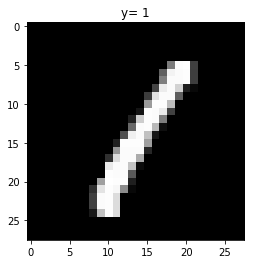

In [10]:
show_data(train_dataset[3])

 The fourth sample is a "1".

Plot the third sample.

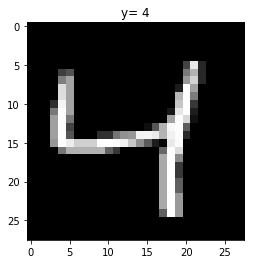

In [11]:
show_data(train_dataset[2])

<a id="ref3"></a>
### Build a Convolutional Neral Network Class 

Build a Convolutional Network class with two Convolutional layers and one fully connected layer. Pre-determine the size of the final output matrix. The parameters in the constructor are the number of output channels for the first and second layer.

In [12]:
class CNN(nn.Module):
    def __init__(self,out_1=16,out_2=32):
        
        super(CNN,self).__init__()
        #first Convolutional layers
        self.cnn1=nn.Conv2d(in_channels=1,out_channels=out_1,kernel_size=5,padding=2)
        #activation function 
        self.relu1=nn.ReLU()
        #max pooling 
        self.maxpool1=nn.MaxPool2d(kernel_size=2)
        #second Convolutional layers
        self.cnn2=nn.Conv2d(in_channels=out_1,out_channels=out_2,kernel_size=5,stride=1,padding=2)
        #activation function 
        self.relu2=nn.ReLU()
        #max pooling 
        self.maxpool2=nn.MaxPool2d(kernel_size=2)
        #fully connected layer 
        self.fc1=nn.Linear(out_2*7*7,10)
        
    def forward(self,x):
        #first Convolutional layers
        out=self.cnn1(x)
        #activation function 
        out=self.relu1(out)
        #max pooling 
        out=self.maxpool1(out)
        #first Convolutional layers
        out=self.cnn2(out)
        #activation function
        out=self.relu2(out)
        #max pooling
        out=self.maxpool2(out)
        #flatten output 
        out=out.view(out.size(0),-1)
        #fully connected layer
        out=self.fc1(out)
        
        return out
    
    def activations(self,x):
        #outputs activation this is not necessary just for fun 
        z1=self.cnn1(x)
        a1=self.relu1(z1)
        out=self.maxpool1(a1)
        
        z2=self.cnn2(out)
        a2=self.relu2(z2)
        out=self.maxpool2(a2)
        out=out.view(out.size(0),-1)
        return z1,a1,z2,a2,out

<a id="ref3"></a>
<h2> Define the Convolutional Neral Network Classifier , Criterion function, Optimizer and Train the  Model  </h2> 

There are 16 output channels for the first layer, and 32 outputs channels for the second layer 

In [13]:
model=CNN(out_1=16,out_2=32)

Plot the model parameters for the kernels before training the kernels. The kernels are initialized randomly.

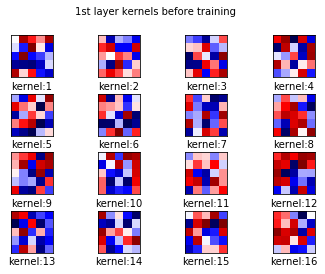

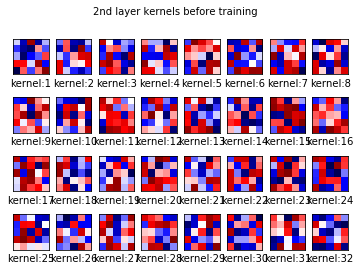

In [14]:
plot_parameters(model.state_dict()['cnn1.weight'],number_rows=4,name="1st layer kernels before training ")
plot_parameters(model.state_dict()['cnn2.weight'],number_rows=4,name='2nd layer kernels before training' )

Define the loss function 

In [15]:
criterion=nn.CrossEntropyLoss()

Define the optimizer class 

In [16]:
learning_rate=0.1
optimizer=torch.optim.SGD(model.parameters(), lr=learning_rate)

Define the dataset loader 

In [17]:

train_loader=torch.utils.data.DataLoader(dataset=train_dataset,batch_size=100)
validation_loader=torch.utils.data.DataLoader(dataset=validation_dataset,batch_size=5000)

Train the model and determine validation accuracy technically test accuracy **(This may take a long time)**

In [18]:
n_epochs=10
loss_list=[]
accuracy_list=[]
N_test=len(validation_dataset)
#n_epochs
for epoch in range(n_epochs):
    print('starting epoch ',epoch)
    for x, y in train_loader:
      

        #clear gradient 
        optimizer.zero_grad()
        #make a prediction 
        z=model(x)
        # calculate loss 
        loss=criterion(z,y)
        # calculate gradients of parameters 
        loss.backward()
        # update parameters 
        optimizer.step()
        
        
        
    correct=0
    #perform a prediction on the validation  data  
    for x_test, y_test in validation_loader:

        z=model(x_test)
        _,yhat=torch.max(z.data,1)

        correct+=(yhat==y_test).sum().item()
        
   
    accuracy=correct/N_test

    accuracy_list.append(accuracy)
    
    loss_list.append(loss.data)


starting epoch  0
starting epoch  1
starting epoch  2
starting epoch  3
starting epoch  4
starting epoch  5
starting epoch  6
starting epoch  7
starting epoch  8
starting epoch  9


<a id="ref3"></a>
<h2 align=center>Analyse Results</h2> 

Plot the loss and accuracy on the validation data:

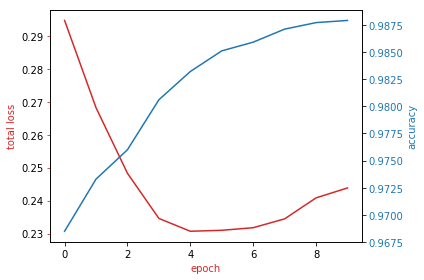

In [19]:
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.plot(loss_list,color=color)
ax1.set_xlabel('epoch',color=color)
ax1.set_ylabel('total loss',color=color)
ax1.tick_params(axis='y', color=color)
    
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('accuracy', color=color)  
ax2.plot( accuracy_list, color=color)
ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout()

View the results of the parameters for the Convolutional layers 

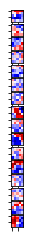

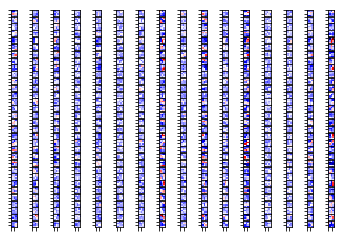

In [20]:
plot_channels(model.state_dict()['cnn1.weight'])
plot_channels(model.state_dict()['cnn2.weight'])

Consider the following sample 

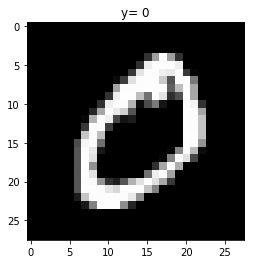

In [21]:
show_data(train_dataset[1])

Determine the activations 

In [22]:
out=model.activations(train_dataset[1][0].view(1,1,28,28))

In [23]:
A=out[1]
A.shape

torch.Size([1, 16, 28, 28])

Plot out the first set of activations 

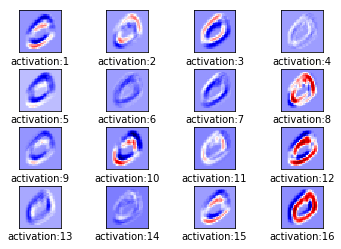

In [24]:
plot_activations(out[0],number_rows=4,name="first feature map")

The image below is the result after applying the relu activation function 

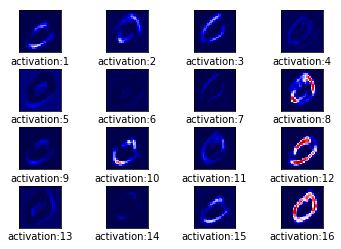

In [25]:
plot_activations(out[1],number_rows=4,name="first feature map after relu")

The image below is the result of the activation map after the second output layer.

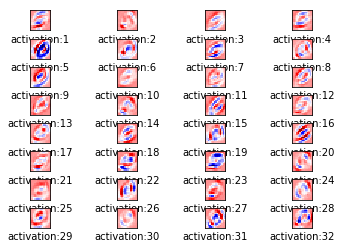

In [26]:
plot_activations(out[2],number_rows=32//4,name="second feature map")

The image below is the result of the activation map after applying the second relu  

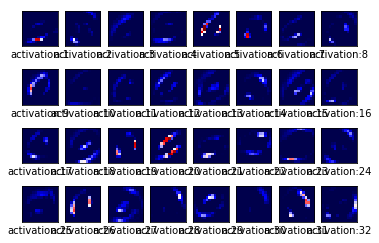

In [27]:
plot_activations(out[3],number_rows=4,name="second feature map after relu")

we can  see the result for the third sample 

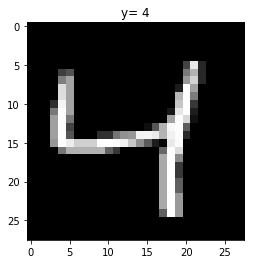

In [28]:
show_data(train_dataset[2])

In [29]:
out=model.activations(train_dataset[2][0].view(1,1,28,28))

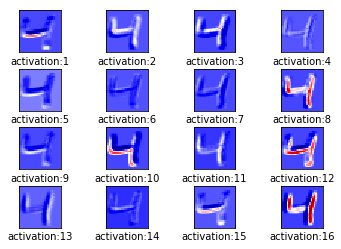

In [30]:
plot_activations(out[0],number_rows=4,name="first feature map")

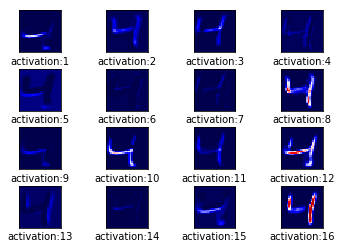

In [31]:
plot_activations(out[1],number_rows=4,name="first feature map ")

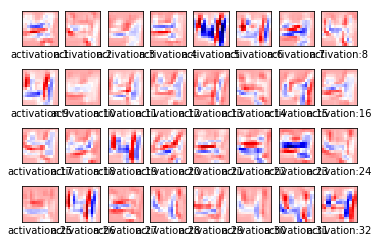

In [32]:
plot_activations(out[2],number_rows=4,name="second feature map ")

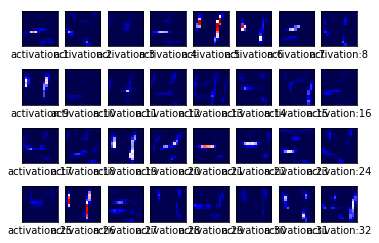

In [33]:
plot_activations(out[3],number_rows=4,name="second feature map ")

Plot the first five miss-classified samples:

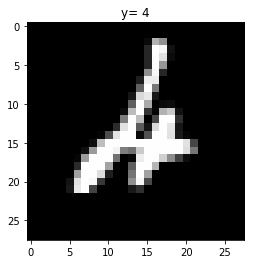

yhat: tensor([2])


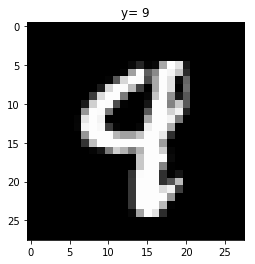

yhat: tensor([4])


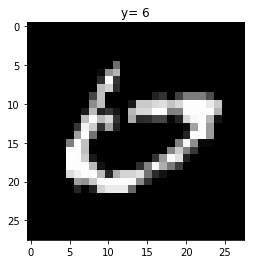

yhat: tensor([0])


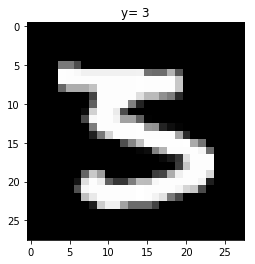

yhat: tensor([5])


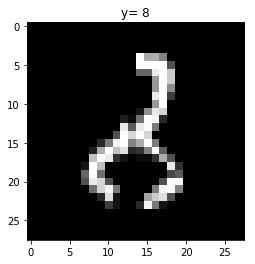

yhat: tensor([2])


In [34]:
count=0
for x,y in torch.utils.data.DataLoader(dataset=validation_dataset,batch_size=1):

    z=model(x)
    _,yhat=torch.max(z,1)
    if yhat!=y:
        show_data((x,y))

        plt.show()
        print("yhat:",yhat)
        count+=1
    if count>=5:
        break 
        

### About the Authors:  
[Joseph Santarcangelo]( https://www.linkedin.com/in/joseph-s-50398b136/) has a PhD in Electrical Engineering. His research focused on using machine learning, signal processing, and computer vision to determine how videos impact human cognition. 

Other contributors: [Michelle Carey](  https://www.linkedin.com/in/michelleccarey/), [Mavis Zhou](  https://www.linkedin.com/in/jiahui-mavis-zhou-a4537814a/)  

Thanks to Magnus [Erik Hvass Pedersen](http://www.hvass-labs.org/) whos tutorials  helped me understand convolutional Neral Network

<hr>

Copyright &copy; 2018 [cognitiveclass.ai](cognitiveclass.ai?utm_source=bducopyrightlink&utm_medium=dswb&utm_campaign=bdu). This notebook and its source code are released under the terms of the [MIT License](https://bigdatauniversity.com/mit-license/).